In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
mep = pd.read_csv('retweets.csv')

In [ ]:
mep.shape

In [ ]:
mep.columns

Delete the records with not English languages

In [ ]:
mep.lang

In [ ]:
mep = mep.loc[mep.lang == 'en']

In [ ]:
import tweepy
auth = tweepy.OAuthHandler('hsaHW0P7kFtP7yiOTWV6E5Cmz', 'A1fgwDsjBQ48dYM8xHqq1fafs8sJpOAj9m9QFkEmqBjorpEk4X')

In [ ]:
mep

In [ ]:
origTweetList = mep.origTweetId.tolist()

In [ ]:
try:
    redirect_url = auth.get_authorization_url()
except tweepy.TweepError:
    print('Error! Failed to get request token.')

In [ ]:
# api = tweepy.API(auth)
# origText = []
# for tweetid in origTweetList:
#     try:
#         tweet = api.get_status(tweetid)
#         origText.append(tweet.text)
#         print(tweet.text)
#     except:
#         origText.append('')
#         print(' ')

https://stackoverflow.com/questions/44581647/retrieving-a-list-of-tweets-using-tweet-id-in-tweepy

In [ ]:
import tweepy

import time

t0 = time.time()

def lookup_tweets(tweet_IDs, api):
    full_tweets = []
    tweet_count = len(tweet_IDs)
    try:
        for i in range((tweet_count // 100) + 1):
            # Catch the last group if it is less than 100 tweets
            end_loc = min((i + 1) * 100, tweet_count)
            full_tweets.extend(
                api.statuses_lookup(id_=tweet_IDs[i * 100:end_loc])
            )  
        return full_tweets
    except tweepy.TweepError:
        print('Something went wrong, quitting...')

auth = tweepy.OAuthHandler('hsaHW0P7kFtP7yiOTWV6E5Cmz', 'A1fgwDsjBQ48dYM8xHqq1fafs8sJpOAj9m9QFkEmqBjorpEk4X')

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# do whatever it is to get por.TweetID - the list of all IDs to look up

results = lookup_tweets(origTweetList, api)

final_dic = {}

t1 = time.time()
total = t1-t0
print(total)

In [ ]:
for tweet in results:
    if tweet:
        final_dic[tweet.id] = tweet.text

In [ ]:
import pprint
# pprint.pprint(final_dic)
len(final_dic)

In [ ]:
tweet_text = pd.DataFrame.from_dict(final_dic, orient='index', columns=['tweetText'])

## Cross Validate that the number of rows is **10126**

### Something to investigate: Do we have duplicate tweets on the dataset?
### mep rows: 13796
### mep.origTweetId.unique(): 10834

In [ ]:
len(mep.origTweetId.unique())

In [ ]:
tweet_text

In [ ]:
mepExt = pd.merge(mep, tweet_text, left_on='origTweetId', right_index=True, how='inner')

In [ ]:
group = mepExt.groupby('origMepGroupShort').count()
groupFiltered = group.loc[group.origUserId > 50]
mepExt = mepExt.loc[mepExt.origMepGroupShort.isin(list(groupFiltered.index))]

In [ ]:
mepExt

In [ ]:
export = mepExt.to_csv(r'C:\Users\Ion\Documents\GitHub\Clustering-and-Classification-of-MEPs-Tweets\fullRetweets.csv',  index = None, header=True)

## Finish the clearing part -- Exporting the CSV so I don't need to run the proccess over and over again

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_columns", 30)
%matplotlib inline

fullRetweets = pd.read_csv('FullRetweets.csv')

In [ ]:
fullRetweets

## Remember to do something with word clouds
https://github.com/amueller/word_cloud

In [ ]:
import wordcloud
import matplotlib
import PIL

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

# another set of stopwords

from nltk.corpus import stopwords
import nltk
import sklearn as sk
nltk.download('stopwords')

In [ ]:
clean_text = fullRetweets.tweetText.drop_duplicates()

In [ ]:
corpus = list(clean_text)

In [ ]:
from sklearn.feature_extraction import text 

my_additional_stop_words = ['http', 'https', 'amp', 'timmermans', 'timkirkhopemep', 'etuc_ces', 'kurdish', 'europe', 'eu', 'ep', 'european', 'parliament']

stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [ ]:
my_stop_words = set(stopwords.words('english')) 
vectorizer = CountVectorizer(lowercase=True, min_df=10, max_df=0.6, stop_words = stop_words)
X = vectorizer.fit_transform(corpus)
X.shape
# vectorizer2 = TfidfVectorizer(lowercase=True, min_df=10, max_df=0.5, stop_words='english')
# X2 = vectorizer2.fit_transform(corpus)

In [ ]:
kmeans = KMeans(n_clusters=5).fit(X)

In [ ]:
cluster_labels = kmeans.fit_predict(X)

In [ ]:
metrics.silhouette_score(X, labels=cluster_labels)

In [ ]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(5):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :15]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

In [ ]:
Y = vectorizer.transform(["brexit is coming"])
prediction = kmeans.predict(Y)
print(prediction)

In [ ]:
from yellowbrick.cluster import InterclusterDistance
model = KMeans(6)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1,9))

visualizer.fit(X)
visualizer.show()

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

plt.figure(figsize=(4 * 4,  2 * 8))

scores = {}
for n_clusters in range(2, 10):
    plt.subplot(4, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

In [ ]:
sorted(scores.items(), key=lambda kv: kv[1], reverse=True)

## Classification

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier

import nltk
import sklearn as sk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_columns", 30)
%matplotlib inline

fullRetweets = pd.read_csv('FullRetweets.csv')

In [89]:
fullRetweets

,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupId,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,retweetMepId,retweetMepName,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang,tweetText
0,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed Jul 04 11:05:03 +0000 2012,220473289259233285,Sun Dec 07 21:46:00 +0000 2014,541710240014942209,en,Euro Parliament votes overwhelmingly to reject...
1,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,1668992125,NathanGillMEP,124965,Nathan GILL,6,EFDD,27,GBR,Fri Jul 05 08:00:23 +0000 2013,353060776707235841,Thu Jun 18 08:52:51 +0000 2015,611456527409524736,en,"US have one currency, one Central Bank and one..."
2,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,21648649,maritaulvskog,96672,Marita ULVSKOG,1,S&D,26,SWE,Sat May 17 12:47:17 +0000 2014,467647542378123264,Wed Sep 16 09:15:06 +0000 2015,644077036022165504,en,More jobs for young people is my top priority ...
3,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Thu Dec 04 22:21:10 +0000 2014,540631925145493504,en,"Vote #Labour, get Tory. Vote Tory, get Labour...."
4,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Sun Mar 29 18:53:32 +0000 2015,582254277122473984,en,"Vote #Labour, get Tory. Vote Tory, get Labour...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12903,1485429175,JSaryuszWolski,28297,Jacek SARYUSZ-WOLSKI,4,EPP,20,POL,539156512,ZdzKrasnodebski,124891,Zdzisław KRASNODĘBSKI,5,ECR,20,POL,Sun Jan 24 13:17:25 +0000 2016,691248438504210432,Mon Jan 25 08:21:14 +0000 2016,691536290198745088,en,Drastic drop in positive EU perception in Pola...
12904,829060856,TheresaMEP,124961,Theresa GRIFFIN,1,S&D,27,GBR,1354570123,julie4nw,124963,Julie WARD,1,S&D,27,GBR,Sun Jan 24 14:04:13 +0000 2016,691260217288454144,Sun Jan 24 14:54:31 +0000 2016,691272874393485314,en,I'm with @UKYP North West now in Knowsley - gr...
12905,829060856,TheresaMEP,124961,Theresa GRIFFIN,1,S&D,27,GBR,202610289,akhanmep,124962,Afzal KHAN,1,S&D,27,GBR,Sun Jan 24 14:12:29 +0000 2016,691262296396599296,Sun Jan 24 14:21:13 +0000 2016,691264493725335552,en,Listening to some fab ideas from young people ...
12906,829060856,TheresaMEP,124961,Theresa GRIFFIN,1,S&D,27,GBR,1354570123,julie4nw,124963,Julie WARD,1,S&D,27,GBR,Sun Jan 24 14:12:29 +0000 2016,691262296396599296,Sun Jan 24 14:54:26 +0000 2016,691272856739659776,en,Listening to some fab ideas from young people ...


In [90]:
classif_tweets = fullRetweets[['tweetText', 'origMepGroupShort']]

In [91]:
classif_tweets = classif_tweets.drop_duplicates()

In [92]:
classif_tweets

,tweetText,origMepGroupShort
0,Euro Parliament votes overwhelmingly to reject...,EFDD
1,"US have one currency, one Central Bank and one...",S&D
2,More jobs for young people is my top priority ...,S&D
3,"Vote #Labour, get Tory. Vote Tory, get Labour....",EFDD
5,Answering my question in ECR Group J-C Juncker...,ECR
...,...,...
12901,Time to lock EU leaders in a room to sort #ref...,ALDE
12903,Drastic drop in positive EU perception in Pola...,EPP
12904,I'm with @UKYP North West now in Knowsley - gr...,S&D
12905,Listening to some fab ideas from young people ...,S&D


Let's first investigate the balance of different tweets between the different political parties.

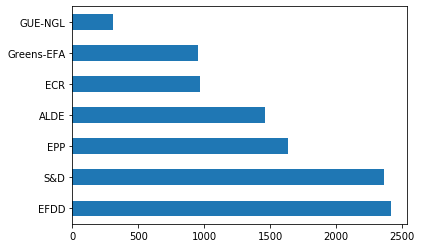

In [93]:
classif_tweets.origMepGroupShort.value_counts().plot(kind='barh')
plt.show()

* We notice that the data are quite unbalanced, might have to think what we should do about that
* Let's create a ```dummy classifier``` who's score will be our threshold

In [94]:
X = classif_tweets.tweetText
y = classif_tweets.origMepGroupShort
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
dummy_clf.predict(X)

array(['EFDD', 'EFDD', 'EFDD', ..., 'EFDD', 'EFDD', 'EFDD'], dtype='<U4')

In [95]:
dummy_clf.score(X, y)

0.23935854286279945

## Further cleaning

We have to create a **bag of words** is which we will do the classification

In [123]:
STOPWORDS = set(stopwords.words('english'))
my_additional_stop_words = ['http', 'https', 'amp', 'timmermans',
                            'timkirkhopemep', 'etuc_ces', 'europe', 'eu', 'ep',
                            'european', 'parliament', 'today', 'tonight', 'tomorrow', 'morning',
                           'see', 'want']
STOPWORDS.update(my_additional_stop_words)
def stopwords(text):
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

classif_tweets.tweetText = classif_tweets.tweetText.apply(lambda x: stopwords(x))

In [125]:
import string
import re

In [126]:
### Remove Punctuation

def remove_punctuation(text):
    no_punc = "".join([c for c in text if c not in string.punctuation])
    return no_punc

classif_tweets['tweetText'] = classif_tweets['tweetText'].apply(lambda x: remove_punctuation(x)) 

In [127]:
### Remove URLS

def remove_urls(text):
    no_url = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    return no_url
classif_tweets['tweetText'] = classif_tweets['tweetText'].apply(lambda x: remove_urls(x)) 

In [128]:
classif_tweets.tweetText

0        euro votes overwhelmingly reject acta commissi...
1        us one currency one central bank one govt one ...
2        jobs young people top priority socialdemocrate...
3        vote labour get tory vote tory get labour vote...
5        answering question ecr group jc juncker confir...
                               ...                        
12901    time lock leaders room sort refugeecrisis poli...
12903    drastic drop positive perception poland effect...
12904    im ukyp north west knowsley great meet myps ac...
12905    listening fab ideas young people across nw tac...
12907    first big banks big pharma whose interests wor...
Name: tweetText, Length: 10102, dtype: object

In [129]:
my_tags = list(classif_tweets.origMepGroupShort.unique())

In [130]:
X = classif_tweets.tweetText
y = classif_tweets.origMepGroupShort

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

## Naive Bayes

In [131]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.5334872979214781
              precision    recall  f1-score   support

        EFDD       0.71      0.24      0.36       435
         S&D       0.88      0.05      0.09       287
         ECR       0.56      0.90      0.69       754
        ALDE       0.72      0.55      0.63       500
         EPP       0.00      0.00      0.00        88
  Greens-EFA       0.93      0.04      0.08       297
     GUE-NGL       0.42      0.79      0.54       670

    accuracy                           0.53      3031
   macro avg       0.60      0.37      0.34      3031
weighted avg       0.63      0.53      0.47      3031



C:\Users\Ion\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [132]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(nb, X, y, cv=5)
scores

array([0.5034585 , 0.52868447, 0.52003958, 0.50049554, 0.50818047])

In [133]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
print(cross_val_score(nb, X, y, cv=k_fold, n_jobs=1))

[0.53488372 0.54230579 0.5450495  0.55643564 0.55445545]


In [136]:
%matplotlib inline

from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', stopwords=STOPWORDS,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [138]:
def plot_word_cloud_for_category(df, category):
    text_df = df.loc[df.origMepGroupShort == str(category)]

    texts = ''    
    for index, item in text_df.iterrows():
        texts = texts + ' ' + item['tweetText']
    plot_word_cloud(texts)

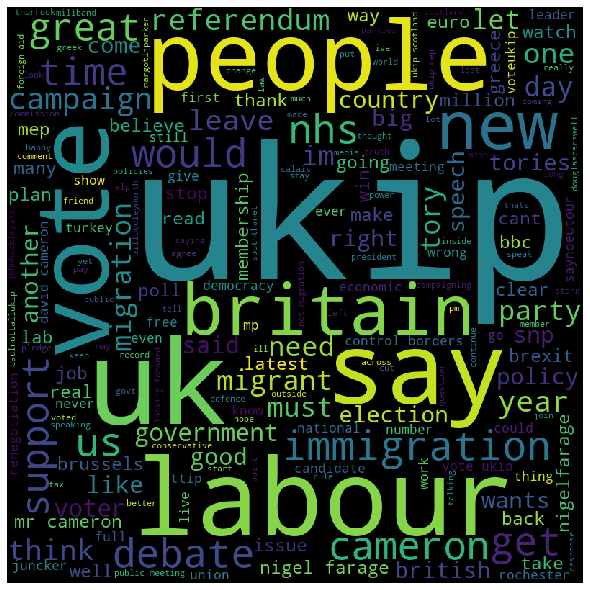

In [139]:
plot_word_cloud_for_category(classif_tweets,'EFDD')

We only have achieved 50% accurancy. Let's try another method

## Stohastic Gradient Descend

In [140]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.6090399208182118
              precision    recall  f1-score   support

        EFDD       0.60      0.47      0.53       435
         S&D       0.61      0.27      0.38       287
         ECR       0.60      0.88      0.71       754
        ALDE       0.64      0.66      0.65       500
         EPP       0.73      0.43      0.54        88
  Greens-EFA       0.66      0.29      0.41       297
     GUE-NGL       0.60      0.67      0.63       670

    accuracy                           0.61      3031
   macro avg       0.63      0.52      0.55      3031
weighted avg       0.62      0.61      0.59      3031



It seems we did better, achieving 60%, which is 10% better than the Naive Bayes

In [141]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

C:\Users\Ion\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ion\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.605080831408776
              precision    recall  f1-score   support

        EFDD       0.50      0.52      0.51       435
         S&D       0.49      0.36      0.41       287
         ECR       0.71      0.81      0.76       754
        ALDE       0.63      0.60      0.62       500
         EPP       0.77      0.45      0.57        88
  Greens-EFA       0.48      0.35      0.40       297
     GUE-NGL       0.59      0.67      0.63       670

    accuracy                           0.61      3031
   macro avg       0.60      0.54      0.56      3031
weighted avg       0.60      0.61      0.60      3031



In [142]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
               ])
X_train, y_train = logreg.fit(X_train, y_train)

In [143]:
classif_tweets.tweetText.apply(lambda x: len(x.split(' '))).sum()

109774